<img src="logo.png"/>

<h1 align=center><font size = 5> REINFORCEMENT LEARNING: FROM BASIC TO ADVANCED</font></h1>

##  Table of contents
<div class="alert alert-block alert-info" style="margin-top: 20px">
<br>
- <p><a href="#ref1">Goals?</a></p>
- <p><a href="#ref2">Requirements?</a></p>
- <p><a href="#ref3">What is Reinforcement Learning?</a></p>
- <p><a href="#ref4">Reinforcement Learning Approaches?</a></p>
- <p><a href="#ref4">Deep Reinforcement Learning?</a></p>
- <p><a href="#ref6">Research Areas?</a></p>
- <p><a href="#ref6">Conclusion?</a></p>
- <p><a href="#ref7">References?</a></p>
<p></p>
</div>
<br>

<a id="ref1"></a>
# Goals?
You will have learned:
- What Reinforcement Learning is and how it works
- Understanding some ideas and algorithms from basic to advanced
- The challenges in Reinforcement Learning.
- The lecture is designed to non-RL person.

<a id="ref2"></a>
# Requirement?
You should already know:
- Beginner level Python
- Linear Algebra

- Tensorflow (advanced part only)
- Deep learning ((advanced part only))

Required packages

In [4]:
import numpy as np
import gym
import matplotlib.pyplot as plt
from collections import deque
import random

<a id="ref3"></a>
# What is Reinforcement Learning?

### Definition

Reinforcement learning (RL) is an area of machine learning concerned with how the agent take actions in an environment to maximize discounted cumulative reward.

<img src="images/rl.gif"/>

### The process of RL involves steps:
1. The agent observes a **state** from the **environment**
2. The agent select an **action** using a **policy**
3. The agent executes the **action**
4. The agent observes next **state** from the **environment**
5. The agent receives a **reward** from the **environment**
6. Learning the **policy** based on the experiences
7. Iterate until an *optimal* **policy** is found

### Example environment: CartPole Balancing

Let's use a simulation of a cartpole problem. The goal is to demonstrate, how you can use RL techniques to develop an efficient and safe approach for tackling this problem.

<img src="images/cartpole.gif"/>

A pole is attached by an un-actuated joint to a cart, which moves along a frictionless track. The goal of cartpole problem is to balance the pole. Here are a few things that we must to take care of:

- The problem fails if the pole is more than 12 degrees from vertical.
- The problem fails if the cart moves more than 2.4 units from the center.

Now, we import the cartpole environment from [Gym OpenAI](https://gym.openai.com). Gym OpenAI is a python package with many environments that are used to evaluate reinfocement learning algorithm.

<img src="images/gym.png"/>

In [7]:
env = gym.make('CartPole-v1')

[2019-01-15 10:26:55,081] Making new env: CartPole-v1


There are different aspects that need to be considered here while modeling an RL solution to this problem: rewards, states, and actions.

##### Rewards

Since the agent is reward-motivated and is going to learn how to balance the pole by trial experiences in the environment, we need to decide the rewards and/or penalties and their magnitude accordingly. 

In cartpole problem, a reward of +1 is provided for every timestep that the pole remains upright.

##### State Space

The State Space is the set of all possible situations the cart-pole system could inhabit. The state should contain useful information the agent needs to make the right action.

In cartpole problem, the state has 4 dimensions (4-dimensional states):
- Cart Position (min: -4.8, max: 4.8)
- Cart Velocity (min: -inf, max: inf)
- Pole Angle (min: -24 degrees, max: 24 degrees)
- Pole Velocity (min: -inf, max: inf)

Print the state space:

In [8]:
print(env.observation_space)

Box(4,)


More details:

In [9]:
print(env.observation_space.high)
print(env.observation_space.low)

[  4.80000000e+00   3.40282347e+38   4.18879020e-01   3.40282347e+38]
[ -4.80000000e+00  -3.40282347e+38  -4.18879020e-01  -3.40282347e+38]


##### Action Space

The set of all the actions that our agent can take in a given state.

In cartpole problem, the agent has two actions:
- 0: Push cart to the left
- 1: Push cart to the right

Print the action space:

In [10]:
print(env.action_space)

Discrete(2)


##### Policy

A policy of a RL algorithm is denoted by $\pi$, which is the probability of taking an action $a$ given a state $s$: 
\begin{align}
\pi = {\cal P}(a|s),
\end{align}

The goal of an RL algorithm is to find an optimal policy $\pi^*$ in order to maximize the expected discounted reward as follows:
\begin{align}
J(\pi ) = \mathbb{E}\bigg[\sum\limits_{t = 0}^\infty {{\gamma ^t}r({s_t},{a_t})}\bigg].
\end{align}

$\gamma$ is the discount factor determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective reward, whereas, a discount factor of 0 makes our agent consider only immediate reward, hence making it greedy.

### Solving the environment without Reinforcement Learning

Let's see what would happen if we try to use a heuristic approach to solving the problem without RL.

##### Random search

We create a class called **LinearAgent** which is parameterized by 4 parameters $\theta_0$, $\theta_1$, $\theta_2$, $\theta_3$ (between -1 and 1). The agent takes action based on the rules as follows:
- Push left if $\theta_0 * state[0] + \theta_1 * state[1] + \theta_2 * state[2] + \theta_3 * state[3] < 0$
- Otherwise: push right

<img src="images/random.png"/>

In [39]:
class LinearAgent:

    def __init__(self):
        self.thetas = np.random.rand(4) * 2 - 1

    def policy(self, state):
        z = np.matmul(self.thetas, state)
        return 0 if z < 0 else 1

Function **run_episode**: colects data samples by running the **env** using **agent**. The output will be 3 arrays:
- Array of states
- Array of actions
- Array of rewards

In [58]:
def run_episode(env, agent):
    states = []
    actions = []
    rewards = []

    state = env.reset()
    for _ in range(500):
        action = agent.policy(state)
        states.append(state)
        actions.append(action)

        state, reward, done, info = env.step(action)
        rewards.append(reward)

        if done:
            break

    return np.array(states), np.array(actions), np.array(rewards)

###### **Random search** algorithm: 
1. Create a **agent**
2. For each iteration:
    - Create a **new_agent**

    - Collect an episode using the **new_agent** and compute the total rewards

    - Update the **agent** by **new_agent** if **new_agent** is better than **agent**

In [59]:
def random_search():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    
    best_params = None
    best_reward = 0
    agent = LinearAgent()
    ran_avg_rewards = []
    scores = deque(maxlen=100)
   
    for epi in range(10000):
        new_agent = LinearAgent()
        _,_,rewards = run_episode(env, new_agent)
        total_reward = np.sum(rewards)
        if total_reward > best_reward:
            best_reward = total_reward
            agent = new_agent

        # evaluate the agent
        _,_,rewards = run_episode(env, agent)
        scores.append(np.sum(rewards))
        ran_avg_rewards.append(np.mean(scores))
        
        if (epi%1000==0):
            print("Episode:" + str(epi) +" | Avg Reward: " + str(ran_avg_rewards[epi]))
    
    return ran_avg_rewards

Now, run the random agent and show the performance:

[2019-01-16 11:30:57,578] Making new env: CartPole-v1


Episode:0 | Avg Reward: 153.0
Episode:1000 | Avg Reward: 346.67
Episode:2000 | Avg Reward: 313.31
Episode:3000 | Avg Reward: 354.48
Episode:4000 | Avg Reward: 341.27
Episode:5000 | Avg Reward: 310.83
Episode:6000 | Avg Reward: 363.86
Episode:7000 | Avg Reward: 335.38
Episode:8000 | Avg Reward: 349.39
Episode:9000 | Avg Reward: 339.41


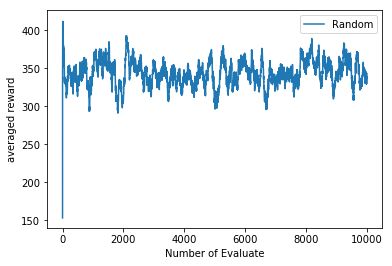

In [60]:
ran_avg_rewards = random_search()

plt.ylabel('averaged reward')
plt.xlabel('Number of Evaluate')
plt.plot(ran_avg_rewards)
plt.legend(['Random'])
plt.show()

Balancing around 7 seconds

##### Heuristic Agent

Now, I use a heuristic as follow:

- The agent pushes cart to the **left** if angle and angular velocity of the pole are less than 0
- The agent pushes cart to the **right** if angle and angular velocity of the pole are greater than 0
- Otherwise, the agent execute a random action.

<img src="images/heuristic.png"/>

In [17]:
class HeuristicAgent:

    def __init__(self):
        pass

    def policy(self, state):
        # Heuristic approach
        if (state[2] < 0 and state[3] < 0):
            return 0
        elif (state[2] > 0 and state[3] > 0):
            return 1
        else:
            return np.random.randint(0, 2)

Run the heuristic agent and show the performance. The program is as follows:

1. Create a **HeuristicAgent**
2. For each iteration:
    - Collect an episode using the **HeuristicAgent** and compute the total rewards

[2019-01-15 10:30:57,636] Making new env: CartPole-v1


Episode:0 | Avg Reward: 500.0
Episode:250 | Avg Reward: 439.67
Episode:500 | Avg Reward: 457.2
Episode:750 | Avg Reward: 452.48
Episode:1000 | Avg Reward: 443.73
Episode:1250 | Avg Reward: 433.83
Episode:1500 | Avg Reward: 454.64
Episode:1750 | Avg Reward: 447.74
Episode:2000 | Avg Reward: 451.51
Episode:2250 | Avg Reward: 444.79
Episode:2500 | Avg Reward: 435.61
Episode:2750 | Avg Reward: 450.72
Episode:3000 | Avg Reward: 446.0
Episode:3250 | Avg Reward: 456.13
Episode:3500 | Avg Reward: 444.55
Episode:3750 | Avg Reward: 445.93
Episode:4000 | Avg Reward: 445.64
Episode:4250 | Avg Reward: 437.7
Episode:4500 | Avg Reward: 441.39
Episode:4750 | Avg Reward: 456.74
Episode:5000 | Avg Reward: 431.67
Episode:5250 | Avg Reward: 452.25
Episode:5500 | Avg Reward: 448.11
Episode:5750 | Avg Reward: 442.46
Episode:6000 | Avg Reward: 447.12
Episode:6250 | Avg Reward: 439.27
Episode:6500 | Avg Reward: 446.74
Episode:6750 | Avg Reward: 448.43
Episode:7000 | Avg Reward: 445.79
Episode:7250 | Avg Rewar

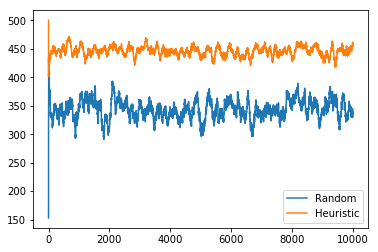

In [18]:
def heuristic():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    
    heu_avg_rewards = []
    scores = deque(maxlen=100)
    agent = HeuristicAgent()
    
    for runs in range(10000):
        _,_,rewards = run_episode(env, agent)
        scores.append(np.sum(rewards))
        heu_avg_rewards.append(np.mean(scores))
        
        if (runs%250==0):
            print("Episode:" + str(runs) +" | Avg Reward: " + str(heu_avg_rewards[runs]))
        
    return heu_avg_rewards

# plot
heu_avg_rewards = heuristic()
plt.plot(range(10000),ran_avg_rewards)
plt.plot(range(10000),heu_avg_rewards)
plt.legend(["Random", 'Heuristic'])
plt.show()

The cart-pole balance in 9s but the agent does not learn anything.

So, now let's use some algorithms to control the cart-pole

# RL Approaches?

I prefer to categorize the RL algorithms into three approaches: value-based approach, policy-based approach and actor-critic approach. Other ways to classification: model-free approach vs model-based approach, on-policy vs off-policy

<img src="images/taxonomy.png"/>

### Value-based approach

A typical value-based approach tries to obtain an optimal policy by finding optimal value functions (${\cal V}$ values) or action-value function (${\cal Q}$ values). 

##### Value function ${\cal V}(s_t)$

The value of state $s$ is defined to be the expected discounted reward which the agent can get if the agent starts in state $s$. Formally, this can be written as:

\begin{align}
{\cal V} (s_t) = \mathbb{E}\bigg[\sum\limits_{t' = t}^T {{\gamma ^{t'-t}}r({s_{t'}},{a_{t'}})}\bigg].
\end{align}

<img src="images/v_value.png"/>

Assume we have a cheat sheet scoring every state: 

\begin{align}
{\cal V}(s_t).
\end{align}

We can simply look at the cheat sheet and find what is the next most rewarding state and take the corresponding action.

##### Action-value function ${\cal Q}(s_t, a_t)$

Action-value function ${\cal Q}$ measures the expected discounted rewards of taking an action $a_t$ at state $s_t$

\begin{align}
{\cal Q} (s_t,a_t) = \mathbb{E}\bigg[\sum\limits_{t' = t}^T {{\gamma ^{t'-t}}r({s_{t'}},{a_{t'}})}\bigg].
\end{align}

<img src="images/q_value.png"/>

##### Methods to estimate ${\cal V}$ and ${\cal Q}$

###### Dynamic Programming (DP)

Dynamic Programming is a very general solution method for problems which have two properties:
1. Optimal substructure
- Principle of optimality applies
- Optimal solution can be decomposed into subproblems
2. Overlapping subproblems
- Subproblems recur many times
- Solutions can be cached and reused

Dynamic programming assumes *full knowledge* of the MDP (E.g. we know everything about the environment).

I ignore the DP-based algorithms because it is difficult to solve *unknown* MDP

###### Monte-Carlo (MC)

- MC methods estimate ${\cal Q}$ directly from episodes of experience
- MC is model-free: no knowledge of MDP transitions / rewards
- MC learns from complete episodes.
- Can only apply MC to episodic MDPs (All episodes must be terminated)

Now, we try to use MC method to control cartpole problem. First, we need to build a Q-table. 

- The Q-table is a matrix where we have a row for each state (discrete state) and a column for each action (2 actions). It's first initialized to 0, and then values are updated after training.

In cartpole, the state space is a continous state space. Thus, we need to discretize the state space to discrete state. The discrete intervals are defined as follows:

- Cart Position ($x$) is devided into 1 part: [-4.8:4.8]
- Cart Velocity ($\dot{x}$) is devided into 8 parts: [-3:-2.25], [-2.25:-1.5], [-1.5:-0.75], [-0.75:0], [0:0.75], [0.75:1.5], [1.5:2.25], [2.25:3]
- Pole Angle ($\theta$) is devided into 8 parts (in degrees): [-24:-18], [-18:-12], [-12:-6], [-6:0], [0:6], [6:12], [12:18], [18:24]
- Pole Velocity ($\dot{\theta}$) is devided into 8 parts: [-2:-1.5], [-1.5:-1], [-1:-0.5], [-0.5:0], [0:0.5], [0.5:1], [1:1.5], [1.5:2]

Totally, we have 512 states. The form of Q-table as follows:

<img src="images/q_table.png"/>

We need some functions:
- **discretize_val**: converts each dimensional state to particular interval.
- **obs_to_state**: converts a state to a index in the table (from 0 to 511)

In [53]:
def discretize_val(val, min_val, max_val, num_states):
    state = int(num_states * (val - min_val) / (max_val - min_val))
    if state >= num_states:
        state = num_states - 1
    if state < 0:
        state = 0
    return state

def get_state_idx(state):
    num_interval = [1, 8, 8, 8]
    lower_bounds = [-4.8, -3, -0.418, -2]
    upper_bounds = [4.8, 3, 0.418, 2]

    state_idx = []
    for ob, lower, upper, num in zip(state, lower_bounds, upper_bounds, num_interval):
        state_idx.append(discretize_val(ob, lower, upper, num))
    
    return state_idx[1] * 64 + state_idx[2] * 8 + state_idx[3]

For example, we have a state is [1.0, 1.0, -0.1, 1.0]. This state will equivalent to the row 350 in the Q-table

In [54]:
print(get_state_idx(np.array([1.0, 1.0, -0.1, 1.0])))

350


**get_discounted_rewards**: return a discounted reward of each state in a episode. $R_t = \sum\limits_{t' = t}^T {{\gamma ^{t'-t}}r({s_{t'}},{a_{t'}})}$

In [47]:
def get_discounted_rewards(rewards, gamma):
    future_discounted_reward = 0
    discounted_rewards = np.empty_like(rewards, dtype=np.float64)
    for i in range(rewards.shape[0] - 1, -1, -1):
        discounted_rewards[i] = rewards[i] + gamma * future_discounted_reward
        future_discounted_reward = discounted_rewards[i]

    return discounted_rewards

Assume that we have an array of 10 rewards at 10 states [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]. The function will return as follows:

In [55]:
rewards = np.array([1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0])
print(get_discounted_rewards(rewards, 0.99))

[ 9.5617925   8.64827525  7.72553056  6.79346521  5.85198506  4.90099501
  3.940399    2.9701      1.99        1.        ]


Create **MCAgent** class with some methods:
1. **init**: 
    - define some hyperparameters ($\gamma$, $\epsilon$, $\epsilon$ decay)
    - create Q-table (512x2)
    - create a table to count the number of visited states
2. **policy**: using Q table to take action. Here is a greedy-epsilon policy

\begin{equation} 
\pi(a|s) = \begin{cases}
argmax{Q(s,a)} & random > \epsilon\\
\textit{a random action} & random < \epsilon
\end{cases}
\end{equation}

- **update**: using sampled episode to update the Q action-values in Q-table. Particularly, 
    * First, we find the total discounted reward $G_t$ (total discounted rewards from $s_t$ to the end). $G_t = \sum\limits_{t' = t}^T {{\gamma ^{t'-t}}r({s_{t'}},{a_{t'}})}$

    * We update the action value function by adding a small portion of the difference between new estimate $G_t$ and the current action value $Q(s_t, a_t)$ back to itself.

\begin{equation} 
Q(s_t, a_t)=Q(s_t,a_t)+\alpha(G_t−Q(s_t,a_t))
\end{equation}

This approach creates a running mean from a stream of estimates. With many episodes, $Q(s_t, a_t)$ will converge to the true value.

<img src="images/MC.png"/>

In the code below:

\begin{equation} 
Q(s_t, a_t) = Q(s_t, a_t) + \frac{1}{\textit{number of visited state $s_t$ and take action $a_t$}}(G_t - Q(s_t, a_t))
\end{equation}

In [46]:
class MCAgent(object):
    def __init__(self):
        self.gamma = 1.0
        self.eps = 0.1
        self.eps_decay = 0.99999

        self.Q = np.zeros((512, 2))
        self.Q_num = np.zeros((512, 2))

    def policy(self, state):
        state_idx = get_state_idx(state)

        random = np.random.rand(1)[0]
        if random > self.eps:
            action_values = self.Q[state_idx, :]
            return np.argmax(action_values)
        else:
            return np.random.randint(0, 2)

    def update(self, states, actions, rewards):
        discounted_rewards = get_discounted_rewards(np.array(rewards), self.gamma)
        for state, action, disc_rew in zip(states, actions, discounted_rewards):
            state_idx = get_state_idx(state)

            # incremental averaging
            self.Q_num[state_idx, action] += 1
            self.Q[state_idx, action] += (disc_rew - self.Q[state_idx, action]) / self.Q_num[state_idx, action]

        self.eps *= self.eps_decay

Now, run the MC algorithm and report the performance. The program runs as follows:
1. For each iteration
2. Obtain the data by running the **env** using **MCAgent**
3. Update agent using the colected data.

[2019-01-15 10:46:26,656] Making new env: CartPole-v1


Episode:0 | Avg Reward: 10.0
Episode:250 | Avg Reward: 109.3
Episode:500 | Avg Reward: 113.1
Episode:750 | Avg Reward: 122.84
Episode:1000 | Avg Reward: 130.69
Episode:1250 | Avg Reward: 117.28
Episode:1500 | Avg Reward: 123.18
Episode:1750 | Avg Reward: 125.23
Episode:2000 | Avg Reward: 124.97
Episode:2250 | Avg Reward: 130.03
Episode:2500 | Avg Reward: 122.72
Episode:2750 | Avg Reward: 122.97
Episode:3000 | Avg Reward: 122.71
Episode:3250 | Avg Reward: 124.83
Episode:3500 | Avg Reward: 124.32
Episode:3750 | Avg Reward: 122.73
Episode:4000 | Avg Reward: 123.4
Episode:4250 | Avg Reward: 124.54
Episode:4500 | Avg Reward: 125.87
Episode:4750 | Avg Reward: 124.11
Episode:5000 | Avg Reward: 124.07
Episode:5250 | Avg Reward: 124.42
Episode:5500 | Avg Reward: 123.24
Episode:5750 | Avg Reward: 126.18
Episode:6000 | Avg Reward: 123.08
Episode:6250 | Avg Reward: 119.45
Episode:6500 | Avg Reward: 127.88
Episode:6750 | Avg Reward: 122.84
Episode:7000 | Avg Reward: 135.12
Episode:7250 | Avg Reward

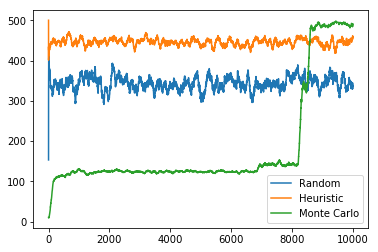

In [21]:
def monte_carlo():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    
    agent = MCAgent()
    mc_avg_rewards = []
    scores = deque(maxlen=100)
    
    for run in range(10000):
        states, actions, rewards = run_episode(env, agent)
        # update Q table
        agent.update(states, actions, rewards)
        
        # for plot
        scores.append(np.sum(rewards))
        mc_avg_rewards.append(np.mean(scores))
        if (run%250==0):
            print("Episode:" + str(run) +" | Avg Reward: " + str(mc_avg_rewards[run]))
 
    return mc_avg_rewards

# plot
mc_avg_rewards = monte_carlo()
plt.plot(range(10000),ran_avg_rewards)
plt.plot(range(10000),heu_avg_rewards)
plt.plot(range(10000),mc_avg_rewards)
plt.legend(["Random", 'Heuristic', "Monte Carlo"])
plt.show()        

Using MC, the pole balance within 10s. MC take 10000 episode to learn the optimal policy.

##### Temporal difference (TD)

In temporal-difference (TD), we look ahead 1 step to estimate a new total reward by adding the action reward to the value function of the next state:

\begin{equation} 
{\cal V}′(s_t)=r_t + 1+\gamma {\cal V}(s_{t+1})
\end{equation}

<img src="images/TD.png"/>

We compute the difference of ${\cal V}(s_t)$ and ${\cal V}′(s_t)$ (E.g. *TD error*). Then we add a portion of the difference back to ${\cal V}(s_t)$.

\begin{equation}
\sigma = r_t+1+\gamma {\cal V}(s_{t+1})−V(s_t) \\
{\cal V}(s_t)={\cal V}(s_t)+\alpha \sigma
\end{equation}

After repeating many episodes, {\cal V} converges to a good estimate.

In fact, we can has n-step look ahead with n approaches infinity. n = 1, this is TD and n = $\inf$, this is Monte-Carlo.

In practial, we use a hyperparameter $\lambda$ , E.g. TD($\lambda$), to tradeoff between TD and Monte-Carlo. We ignore the class of TD($\lambda$) method.

<img src="images/MC_TD.png"/>

##### Q-Learning and SARSA algorithm

The $TD$ error of ${\cal Q}$ values is calculated by:

\begin{align}
TD = r + \gamma {\cal Q}(s',a') - {\cal Q}(s,a)
\end{align}

Based on the choice of $a'$, we can classify TD error into two methods: ${\cal Q}$-Learning algorithm and SARSA algorithm.

In ${\cal Q}$-Learning, $a'$ is chosen to maximize the ${\cal Q}$ value.

\begin{align}
TD_{Q-Learning} = r + \gamma \max \limits _{a'} {\cal Q}(s',a') - {\cal Q}(s,a)
\end{align}

<img src="images/q_learning.png"/>

Now is time for coding. First, we create class **QLearningAgent** with some methods:

1. **init**: 
    * Initialize hyperparameters ($\gamma$, $\epsilon$, $\alpha$)
    * Initialize Q table
2. **policy**:
    * Receive a state and return an action.
    * We using $\epsilon$-greedy policy.
    
\begin{equation} 
a = \begin{cases}
argmax{Q(s,a)} & random > \epsilon\\
\textit{a random action} & random < \epsilon
\end{cases}
\end{equation}

3. **update_epsilon** and **update_alpha** decrease the manitude of $\alpha$ and $\epsilon$ after each episode
4. **update**: Q-learning update as the formula above

In [22]:
class QLearningAgent(object):
    def __init__(self):
        self.gamma = 1.0
        self.eps = 1.0
        self.alpha = 1.0

        self.Q = np.zeros((512, 2))

    def policy(self, state):
        state_idx = get_state_idx(state)

        random = np.random.rand(1)[0]
        if random > self.eps:
            action_values = self.Q[state_idx, :]
            return np.argmax(action_values)
        else:
            return np.random.randint(0, 2)

    def update_epsilon(self, t):
        # Update epsilon
        self.eps =  max(0.01, min(1.0, 1.0 - np.log((t + 1) / 100)))

    def update_alpha(self, t):
        # Update alpha
        self.alpha =  max(0.01, min(1.0, 1.0 - np.log((t + 1) / 100)))

    def update(self, state, action, next_state, reward):

        state_idx = get_state_idx(state)
        next_state_idx = get_state_idx(next_state)

        # TD Update
        maxQ = np.max(self.Q[next_state_idx, :])
        target_Q = reward + self.gamma * maxQ
        self.Q[state_idx, action] += self.alpha * (target_Q - self.Q[state_idx, action])

Run Q-Learning algorithm and report performance. Pseudocode as follows:
1. Create **QLearningAgent**
2. For each episode
    1. Initialize the initial state
    2. For each steps in episode
        * Predict action using QLearningAgent
        * Take the next steps and get the next state and reward.
        * Using the collected data to update **QLearningAgent**
    3. Decrease the value of $\alpha$ and $\epsilon$

[2019-01-15 10:50:24,171] Making new env: CartPole-v1
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


Episode:0 | Avg Reward: 33.0
Episode:250 | Avg Reward: 45.23
Episode:500 | Avg Reward: 497.05
Episode:750 | Avg Reward: 493.66
Episode:1000 | Avg Reward: 496.98
Episode:1250 | Avg Reward: 500.0
Episode:1500 | Avg Reward: 498.77
Episode:1750 | Avg Reward: 495.81
Episode:2000 | Avg Reward: 494.19
Episode:2250 | Avg Reward: 495.94
Episode:2500 | Avg Reward: 497.53
Episode:2750 | Avg Reward: 493.73
Episode:3000 | Avg Reward: 491.18
Episode:3250 | Avg Reward: 497.1
Episode:3500 | Avg Reward: 437.18
Episode:3750 | Avg Reward: 496.97
Episode:4000 | Avg Reward: 495.26
Episode:4250 | Avg Reward: 500.0
Episode:4500 | Avg Reward: 498.97
Episode:4750 | Avg Reward: 494.16
Episode:5000 | Avg Reward: 500.0
Episode:5250 | Avg Reward: 496.35
Episode:5500 | Avg Reward: 499.23
Episode:5750 | Avg Reward: 496.16
Episode:6000 | Avg Reward: 495.03
Episode:6250 | Avg Reward: 490.0
Episode:6500 | Avg Reward: 476.57
Episode:6750 | Avg Reward: 492.17
Episode:7000 | Avg Reward: 497.96
Episode:7250 | Avg Reward: 5

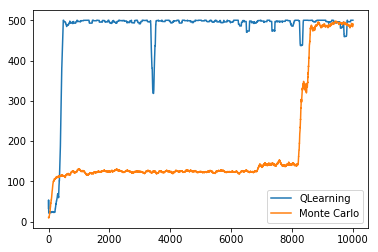

In [23]:
def q_learning():
    qlearning_avg_rewards = []
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    agent = QLearningAgent()
    scores = deque(maxlen=100)

    for epi in range(10000):
        # Run each episode
        state = env.reset()
        total_reward = 0
        for i in range(500):
            action = agent.policy(state)
            next_state, reward, done, info = env.step(action)
            # update
            agent.update(state, action, next_state, reward)

            state = next_state
            total_reward += 1
            if done:
                break

        # for plot
        scores.append(total_reward)
        qlearning_avg_rewards.append(np.mean(scores))

        if (epi%250==0):
            print("Episode:" + str(epi) +" | Avg Reward: " + str(qlearning_avg_rewards[epi]))

        agent.update_epsilon(epi)
        agent.update_alpha(epi)

    return qlearning_avg_rewards
    
# plot
qlearning_avg_rewards = q_learning()
plt.plot(range(10000),qlearning_avg_rewards)
plt.plot(range(10000),mc_avg_rewards)
plt.legend(['QLearning', "Monte Carlo"])
plt.show() 

##### SARSA algorithm

In SARSA learning (**S**tate **A**ction **R**eward **S**tate **A**ction learning), a′ is chosen by $\epsilon$-greedy Q

\begin{align}
TD_{SARSA} = r + \gamma {\cal Q}(s',a') - {\cal Q}(s,a)
\end{align}

<img src="images/sarsa.png"/>

Here is the code of **SARSAAgent**. Almost are the same with **QLearningAgent**. The difference is from **update** method.
- Line 34: the next action is predicted using $\epsilon$-greedy

In [24]:
class SARSAAgent(object):
    def __init__(self):
        self.gamma = 1.0
        self.eps = 1.0
        self.alpha = 1.0

        self.Q = np.zeros((512, 2))

    def policy(self, state):
        state_idx = get_state_idx(state)

        random = np.random.rand(1)[0]
        if random > self.eps:
            action_values = self.Q[state_idx, :]
            return np.argmax(action_values)
        else:
            return np.random.randint(0, 2)

    def update_epsilon(self, t):
        # Update epsilon
        self.eps =  max(0.01, min(1.0, 1.0 - np.log((t + 1) / 100)))

    def update_alpha(self, t):
        # Update alpha
        self.alpha = 0.075
        # self.alpha =  max(0.05, min(1.0, 1.0 - np.log((t + 1) / 100)))

    def update(self, state, action, next_state, reward):

        state_idx = get_state_idx(state)
        next_state_idx = get_state_idx(next_state)

        # TD Update
        next_action = self.policy(next_state)
        target_Q = reward + self.gamma * self.Q[next_state_idx, next_action]
        self.Q[state_idx, action] += self.alpha * (target_Q - self.Q[state_idx, action])


Run Q-Learning algorithm and report performance. Pseudocode as follows:
1. Create **SARSAAgent**
2. For each episode
    1. Initialize the initial state
    2. For each steps in episode
        * Predict action using SarsaAgent
        * Take the next steps and get the next state and reward.
        * Using the collected data to update **SARSAAgent**
    3. Decrease the value of $\alpha$ and $\epsilon$

[2019-01-15 10:57:29,462] Making new env: CartPole-v1
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: divide by zero encountered in log


Episode:0 | Avg Reward: 21.0
Episode:1000 | Avg Reward: 95.27
Episode:2000 | Avg Reward: 183.75
Episode:3000 | Avg Reward: 478.46
Episode:4000 | Avg Reward: 473.09
Episode:5000 | Avg Reward: 493.62
Episode:6000 | Avg Reward: 450.53
Episode:7000 | Avg Reward: 486.52
Episode:8000 | Avg Reward: 454.54
Episode:9000 | Avg Reward: 500.0


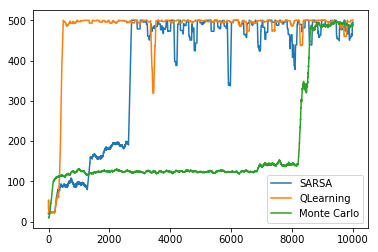

In [25]:
def sarsa():
    sarsa_avg_rewards = []
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    agent = SARSAAgent()
    scores = deque(maxlen=100)

    for epi in range(10000):
        # Run each episode
        state = env.reset()
        total_reward = 0
        for i in range(500):
            action = agent.policy(state)
            next_state, reward, done, info = env.step(action)
            # update
            agent.update(state, action, next_state, reward)

            state = next_state
            total_reward += 1
            if done:
                break

        # for plot
        scores.append(total_reward)
        sarsa_avg_rewards.append(np.mean(scores))
        
        if (epi%1000==0):
            print("Episode:" + str(epi) +" | Avg Reward: " + str(sarsa_avg_rewards[epi]))
            
        agent.update_epsilon(epi)
        agent.update_alpha(epi)

    return sarsa_avg_rewards

# plot
sarsa_avg_rewards = sarsa()
plt.plot(range(10000),sarsa_avg_rewards)
plt.plot(range(10000),qlearning_avg_rewards)
plt.plot(range(10000),mc_avg_rewards)
plt.legend(["SARSA",'QLearning', "Monte Carlo"])
plt.show()

##### Summary on Value-based Approach

- Dynamic programming for *known* model (MDP)
- Monte-Carlo and Temporal Difference for *unknown model*
- MC properties
    - Learn from complete episodes
    - No bootstrapping (E.g. The value is updated using a final reward)
    - High variance, zero bias
- TD properties:
    - Learn from incomplete episodes
    - Bootstrapping (E.g. The value is updated partly using an existing estimate)
    - Low variance, high bias (Sensitive to initial value)


### Policy-based Approach

Policy-based approach focuses on directly optimizing a **parameterized** policy. The **parameterized** policy has the form $\pi_\theta (a|s) = P(a|s;\textbf{$\theta$})$, where $\textbf{$\theta$}$ is parameter vector of the policy.

The objective of RL is maximizing the total discounted reward function:

\begin{align}
J(\pi_\theta) = \mathbb{E}\bigg[\sum\limits_{t = 0}^\infty {{\gamma ^t}r({s_t},{a_t})}\bigg].
\end{align}

Policy gradient is one of the policy search approaches which use gradient descent to update the policy. 

\begin{align}
{{\boldsymbol{\mathrm{\theta}}} _{k + 1}} = {{\boldsymbol{\mathrm{\theta}}} _k} + \alpha {\nabla _{\boldsymbol{\mathrm{\theta}}} }J(\pi_\boldsymbol{\mathrm{\theta}}),
\end{align}

where $\alpha$ denotes a learning rate and $k$ is the current update number. Policy gradient methods guarantee to converge to an optimum (local optimum). The main computation of a policy gradient methods is how to estimate the gradient ${\nabla _{\boldsymbol{\mathrm{\theta}}} }J(\pi_\boldsymbol{\mathrm{\theta}})$

<img src="images/pg.png" width="600"/>

##### Finite Difference Policy Gradient (FD)

The first method is Finite Difference Policy Gradient. 

First, we create a **SigmoidAgent** that is paramerized by 4 parameters between -1 and 1. The network of **SigmoidAgent** is demonstrated as follows:

<img src="images/sigmoid.png"/>

The output of networks ($probs$) is a value between 0 and 1.

Some methods of SigmoidAgent.
- The **sigmoid** function is as follow:

\begin{align}
y(x) = \frac{1}{(1+e^{-x})}
\end{align}

- **policy**: receive a state and return an action. The output of network is used to determine which action the agent should take. 
    + $\pi(a == 1) = probs$
    + $\pi(a == 0) = 1 - probs$

In [26]:
class SigmoidAgent:

    def __init__(self):
        self.thetas = np.random.rand(4) * 2 - 1

    def sigmoid(self, state):
        z = state.dot(self.thetas)
        return 1 / (1 + np.exp(-z))

    def policy(self, state):
        probs = self.sigmoid(state)
        return np.random.binomial(n=1, p=probs, size=1)[0]

The detail of finite difference methods is as follows

<img src="images/fd.png" width="600"/>

[2019-01-15 11:10:14,046] Making new env: CartPole-v1
/anaconda/lib/python2.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: overflow encountered in exp
  


Episode:0 | Avg Reward: 36.0
Episode:1000 | Avg Reward: 10.74
Episode:2000 | Avg Reward: 500.0
Episode:3000 | Avg Reward: 183.57
Episode:4000 | Avg Reward: 10.21


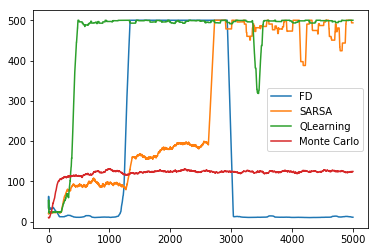

In [31]:
def fd():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    agent = SigmoidAgent()

    # hyper parameters
    learning_rate = 0.000000004
    eps = 1e-7

    fd_avg_rewards = []
    scores = deque(maxlen=100)

    grads = np.asarray(agent.thetas)
    for epi in range(5000):
        # For each parameter of policy
        # Evaluate thetas
        _,_,rewards = run_episode(env, agent)
        J = np.sum(rewards)

        cur_params = np.copy(agent.thetas)
        for i in range(agent.thetas.shape[0]):
            agent.thetas[i] = agent.thetas[i] + eps
            _,_,rewards = run_episode(env, agent)
            Jplus = np.sum(rewards)

            grads[i] = (Jplus - J) / eps

        agent.thetas = cur_params
        # Weight update
        agent.thetas += learning_rate * grads

        # for plot
        scores.append(J)
        fd_avg_rewards.append(np.mean(scores))
        if (epi%1000==0):
            print("Episode:" + str(epi) +" | Avg Reward: " + str(fd_avg_rewards[epi]))
    
    return fd_avg_rewards

# plot
fd_avg_rewards = fd()
plt.plot(range(5000),fd_avg_rewards[0:5000])
plt.plot(range(5000),sarsa_avg_rewards[0:5000])
plt.plot(range(5000),qlearning_avg_rewards[0:5000])
plt.plot(range(5000),mc_avg_rewards[0:5000])
plt.legend(["FD","SARSA",'QLearning', "Monte Carlo"])
plt.show()

- In Cart-Pole, we luckily obtain the obtimal policy. We should stop training until 1500 episodes
- The computation time depends on the number of parameters of the policy.

Advantages:
- Easy to implement, require very little skill
Disadvantages:
- Slow (Because we need to get a lot of episodes)

##### REINFORCE (Monte-Carlo policy gradient)

By using likelihood ratio method, we can get the final estimation of policy gradient as follows (the details can be read at [Link](http://tuyenple.com/projects/rkhs/manuscript.pdf])): 

\begin{align}
{\nabla _{\boldsymbol{\mathrm{\theta}}} }J(\pi_\boldsymbol{\mathrm{\theta}}) = \mathop{\mathbb{E}} \big[ \nabla _{\boldsymbol{\mathrm{\theta}}}\log \pi (s,a) R\big],
\end{align}

where $\nabla _{\boldsymbol{\mathrm{\theta}}}\log \pi (s,a)$ is called **score function** and $R$ is total discounted reward of the episode.

The **score function** can have analytic form by using Softmax policy, Sigmoid policy, or Gaussian policy.

Go back to the cart-pole problem where we use a sigmoid policy. So, the form of **score function** is as follows:

\begin{align}
\nabla _{\boldsymbol{\mathrm{\theta}}}\log \pi (s,a) = \Big[(1 - a) * -\pi (s,a) + a * (1 - \pi(s,a))\Big] * \vec{s}
\end{align}

Intuitively,
- When action is 0: $\nabla _{\boldsymbol{\mathrm{\theta}}}\log \pi (s,a) = -\pi (s,a) * \vec{s}$
- When action is 1: $\nabla _{\boldsymbol{\mathrm{\theta}}}\log \pi (s,a) = (1 - \pi(s,a)) * \vec{s}$

The REINFORCE algorithm is as follows:
1. For each iteration
    1. Collect the episode (line 16)
    2. Calculate total discounted rewards R(line 17)
    3. Calculate score function as the formula above. (line 19)
    4. Get the policy gradient: $grads = score\_function * R$ (line 20)
    5. Update the parameters using policy gradient with learning rate is $\alpha$ (line 25)

[2019-01-15 11:13:20,782] Making new env: CartPole-v1


Episode:0 | Avg Reward: 36.0
Episode:1000 | Avg Reward: 344.71
Episode:2000 | Avg Reward: 313.05
Episode:3000 | Avg Reward: 360.86
Episode:4000 | Avg Reward: 500.0


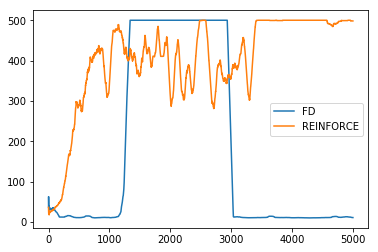

In [33]:
def reinforce():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    agent = SigmoidAgent()

    # hyper parameters
    learning_rate = 0.001
    gamma = 0.99

    reinforce_avg_rewards = []
    scores = deque(maxlen=100)

    for e in range(5000):

        states, actions, rewards = run_episode(env, agent)
        discounted_reward = get_discounted_rewards(rewards, gamma)

        probs = agent.sigmoid(states)
        grads = discounted_reward * \
                (-(1. - actions) *
                 probs + (actions * (1. - probs) )) * \
                states.T

        agent.thetas += learning_rate * np.sum(grads, axis=1)

        # Append for logging and print
        scores.append(np.sum(rewards))
        reinforce_avg_rewards.append(np.mean(scores))
        if (e%1000==0):
            print("Episode:" + str(e) +" | Avg Reward: " + str(reinforce_avg_rewards[e]))
            
    return reinforce_avg_rewards

# plot
reinforce_avg_rewards = reinforce()
plt.plot(range(5000),fd_avg_rewards)
plt.plot(range(5000),reinforce_avg_rewards)
plt.legend(["FD",'REINFORCE'])
plt.show()

Advantages:
- Guaranteed to achieve the convergence to a optimal policy
- Fast (in theory)
REINFORCE properties (similar to MC method):
- Learn from complete episodes
- High variance

In the next part of this lecture, we can replace R with Q action-value function, V value function, or Advantage function to reduce the variance (increase bias)

##### Natural Policy Gradient (NPG)

NPG adds more constraint on the policy gradient. Particularly, to improve training stability, NPG avoids parameter updates that change the policy too much at one step. To measure the closeness between the current policy and the updated policy, it use Kullback-Leibler divergence $d_{KL}(\pi_{\theta} || \pi_{\theta+\Delta\theta})$. Kullback-Leibler divergence $d_{KL}(\pi_{\theta} || \pi_{\theta+\Delta\theta})$ can be approximated by its second order Taylor expansion, i.e., by

\begin{align}
d_{KL}(\pi_{\theta} || \pi_{\theta+\Delta\theta}) \approx \Delta\theta^T F_\theta \Delta\theta,
\end{align}

where $F_\theta$ is **Fisher Information Matrix** (Hessian of log likelihood):

\begin{align}
F_\theta = <\nabla\log\pi_\theta, \nabla\log\pi_\theta ^T>
\end{align}

By restrict the change of our policy to $\Delta\theta^T F_\theta \Delta\theta = \epsilon,$ where $\epsilon$ is very small. We can get the approximate of natural policy gradient:

\begin{align}
\Delta\theta \approx F_\theta^{−1}\nabla_\theta J,
\end{align}

where $\nabla_\theta J$ is policy gradient from REINFORCE. For more detail about natural policy gradient, we can read [here](https://medium.com/@jonathan_hui/rl-natural-policy-gradient-actor-critic-using-kronecker-factored-trust-region-acktr-58f3798a4a93)

That is enough for theory. Now, we go back to the code. The different with REINFORCE is that we need to calculate the inverse of **Fisher Information Matrix**.

We use function **findTheBestLearningRateUsingLineSearch** to find the best learning rate $\alpha$ (my experience). The function return the best learning rate that give the best performance.

In [57]:
def findTheBestLearningRateUsingLineSearch(grads, env, agent):
    best_alpha = 0.0
    best_value = -1000000000000
    numEval = 40
    backup_params = np.copy(agent.thetas)
    for grid in range(numEval):
        alpha_new = 0.01 * (((1.1)**(grid-1))-1) + 0.0000001;

        theta_new = backup_params + alpha_new * grads;
        agent.thetas = theta_new

        states, actions, rewards = run_episode(env, agent)
        if (np.sum(rewards) > best_value):
            best_value = np.sum(rewards);
            best_alpha = alpha_new;

    agent.thetas = backup_params
    return best_alpha

**npg** almost same with REINFORCE. The differences are that:
- We need to calculate the Fisher Information Matrix (line 20)
- We get the natural policy gradient at line 24 by: $\Delta\theta \approx F_\theta^{−1}\nabla_\theta J$,
- We use **findTheBestLearningRateUsingLineSearch** to find the best learning rate $\alpha$ (line 26)

[2019-01-15 11:15:01,627] Making new env: CartPole-v1


Episode:0 | Avg Reward: 36.0
Episode:250 | Avg Reward: 459.15
Episode:500 | Avg Reward: 488.35
Episode:750 | Avg Reward: 383.0
Episode:1000 | Avg Reward: 460.47
Episode:1250 | Avg Reward: 406.01
Episode:1500 | Avg Reward: 461.47
Episode:1750 | Avg Reward: 450.06


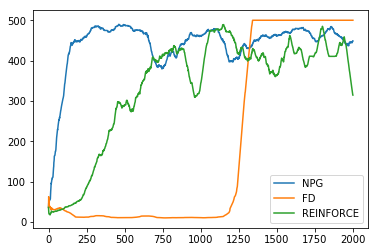

In [34]:
def npg():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    agent = SigmoidAgent()

    # hyper parameters
    gamma = 0.99

    npg_avg_rewards = []
    scores = deque(maxlen=100)

    for e in range(2000):

        states, actions, rewards = run_episode(env, agent)
        discounted_reward = get_discounted_rewards(rewards, gamma)

        probs = agent.sigmoid(states)
        dLogPi = (-(1. - actions) * probs + (actions * (1. - probs) )) * states.T
        sumDLogPi = np.sum(dLogPi, axis=1)
        F = np.dot(sumDLogPi.reshape(-1,1), sumDLogPi.reshape(1,-1))

        vanilla_grads = sumDLogPi * discounted_reward[0]
        natural_grads = np.dot(np.linalg.pinv(F),vanilla_grads)

        learning_rate = findTheBestLearningRateUsingLineSearch(natural_grads, env, agent)
        agent.thetas += learning_rate * natural_grads

        # Append for logging and print
        scores.append(np.sum(rewards))
        npg_avg_rewards.append(np.mean(scores))
        if (e%250==0):
            print("Episode:" + str(e) +" | Avg Reward: " + str(npg_avg_rewards[e]))

    return npg_avg_rewards

# plot
npg_avg_rewards = npg()
plt.plot(range(2000),npg_avg_rewards[0:2000])
plt.plot(range(2000),fd_avg_rewards[0:2000])
plt.plot(range(2000),reinforce_avg_rewards[0:2000])
plt.legend(["NPG","FD",'REINFORCE'])
plt.show()

**Advantage**:
- It guarantees policy improvement

**Disadvantage**
- Calculate $F$ and $F^{-1}$ are expensive (depend on number of state features)

**TRPO** (Trust Region Policy Optimization) and **PPO** (Proximal Policy Optimization) are improvements of Natural Policy Gradient

### Actor Critic Approach

Actor-critic approach proposed a framework which mixes between value-based approach and policy-based approach. Particularly, the framework is divided into two parts: actor part and critic part. 
- The actor part receives a state from an environment and uses a policy to estimate an action. 
- The critic part receives the state and the reward from the environment to evaluate how good at that state. 

The policy of actor part is updated during the learning process based on the TD error from the critic part.

<img src="images/ac.png"/>

REINFORCE becomes Actor-Critic when:
- Replace R (total discounted rewards) with an **approximation** of action-value function Q, value function V or advantage function A.

##### Value Function Approximation

Why do we need to use function approximation:
- There are too many states and/or actions to store in memory
- It is too slow to learn the value of each state individually

How to make **function approximation**
- We approximate the function (Q, or V) using function that is parameterized by parameter $w$

\begin{align}
Q(s,a) \approx Q_w(s,a)
\end{align}

\begin{align}
V(s) \approx V_w(s)
\end{align}

How to represent **function approximation**:
- Tabular (E.g. the Q-table that we use in MC or TD previous section). This representation is hard to deal with highly continous state space 
- Linear function (E.g. $V(s) = w_1*x_1 + w_2*x_2 + \ldots$). This representation cannot deal with highly non-linear problem.
- Deep neural networks. By using deep neural networks, reinforcement learning become **deep** reinforcement learning

The example below use a linear approximation of value function:

\begin{align}
V(s) \approx V_w(s) = w_1*s_1 + w_2*s_2 + w_3*s_3 + w_4*s_4
\end{align}

We make **ACAgent** with some features:
- The parameters of policy is $\theta$
- The policy of value function is $w$
- We also use the sigmoid policy
- **get_dW**: return the gradient of $w$
- **get_dTheta**: return the gradient of $\theta$

In [63]:
class ACAgent:

    def __init__(self):
        # actor params
        self.thetas = np.random.rand(4) * 2 - 1
        # critic params
        self.Ws = np.random.rand(4) * 2 - 1

    def sigmoid(self, state):
        z = state.dot(self.thetas)
        return 1 / (1 + np.exp(-z))

    def policy(self, state):
        probs = self.sigmoid(state)
        return np.random.binomial(n=1, p=probs, size=1)[0]

    def get_dW(self, rewards, states, gamma):
        approximated_V = self.get_V(states)
        discounted_rewards = get_discounted_rewards(rewards, gamma)
        grads = ((discounted_rewards - approximated_V) * states.T).sum(axis=1)

        return grads

    def get_dTheta(self, states, actions, adv):
        probs = self.sigmoid(states)
        grads = adv * \
                (-(1. - actions) *
                 probs + (actions * (1. - probs))) * \
                states.T

        return grads

    def get_V(self, state):
        return np.dot(state, self.Ws)

Here, we use **Monte-Carlo with Value Function Approximation** to make the algorithm. Particularly,

1. Create a **ACAgent** agent.
2. Defind learning rate for actor and critic (line 8 and line 9)
3. For each iteration (line 15)
    1. We collect 1 episode using **ACAgent** agent
    2. Update the critic using the collected episode: $dW = dW + critic\_learning\_rate * (G_t - V_w(s_t)) * \vec{s}$, where G is discounted reward at state $s_t$ and $V_w$ is approximation of V function at state $s_t$.
    3. Update the actor simmilar to REINFORCE but replacing R with $(G_t - V_w(s_t))$


[2019-01-16 12:03:13,504] Making new env: CartPole-v1


Episode:0 | Avg Reward: 52.0
Episode:250 | Avg Reward: 63.07
Episode:500 | Avg Reward: 214.13
Episode:750 | Avg Reward: 287.81
Episode:1000 | Avg Reward: 359.52
Episode:1250 | Avg Reward: 259.68
Episode:1500 | Avg Reward: 382.44
Episode:1750 | Avg Reward: 190.16
Episode:2000 | Avg Reward: 460.67
Episode:2250 | Avg Reward: 467.12
Episode:2500 | Avg Reward: 397.27
Episode:2750 | Avg Reward: 308.62
Episode:3000 | Avg Reward: 348.83
Episode:3250 | Avg Reward: 500.0
Episode:3500 | Avg Reward: 486.42
Episode:3750 | Avg Reward: 498.21


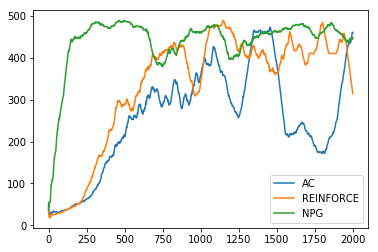

In [64]:
def actor_critic():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    agent = ACAgent()

    # hyper parameters
    actor_learning_rate = 0.001
    critic_learning_rate = 1.e-5
    gamma = 0.99

    ac_avg_rewards = []
    scores = deque(maxlen=100)

    for e in range(4000):

        states, actions, rewards = run_episode(env, agent)

        # Critic update
        dW = agent.get_dW(rewards, states, gamma)
        agent.Ws += critic_learning_rate * dW

        # Actor update
        adv = get_discounted_rewards(rewards, gamma) - agent.get_V(states)
        dTheta = agent.get_dTheta(states, actions, adv)

        agent.thetas += actor_learning_rate * np.sum(dTheta, axis=1)

        # Append for logging and print
        scores.append(np.sum(rewards))
        ac_avg_rewards.append(np.mean(scores))
        if (e%250==0):
            print("Episode:" + str(e) +" | Avg Reward: " + str(ac_avg_rewards[e]))
    
    return ac_avg_rewards

# plot
ac_avg_rewards = actor_critic()
plt.plot(range(2000),ac_avg_rewards[0:2000])
plt.plot(range(2000),reinforce_avg_rewards[0:2000])
plt.plot(range(2000),npg_avg_rewards[0:2000])
plt.legend(["AC",'REINFORCE',"NPG"])
plt.show()

# Deep Reinforcement Learning?

### From Q-Learning to DQN

As I mentioned, in traditional Q-Learning, we use Q-table to approximate the Q function and this representation is difficult to represent highly non-linear problem and highly countinous state and action space.

<img src="images/nn.png"/>

DQN use deep neural networks to represent the Q-Function. In addition, DQN uses two techniques to improve the stable of algorithm:
1. **Target Q network**: DQN used an iterative update that adjusts the ${\cal Q}$ values towards target ${\cal Q}$ values that are only periodically updated, thereby reducing correlations with the target. In the practical implementation, target values are generated by a separate neural network, called target ${\cal Q}$ network, which is a copy of the Q network. The target ${\cal Q}$ network is periodically updated and is decoupled with the updating of ${\cal Q}$ network.
2. **Experience Replay**: DQN uses a biologically inspired mechanism termed **experience replay** that randomizes over the data, thereby removing correlations in the observation sequence and smoothing over changes in the data distribution

In the examples below, I use tensorflow to interact with deep neural networks. Import **tensorflow** and **keras**:

In [1]:
import tensorflow as tf
from tensorflow import keras

/anaconda/lib/python2.7/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Make a **DQNAgent** class with some feature:
- It have a replay memory that stores sample data for later use (line 18)
- It have two neural networks: main Q-network (self.model) and target Q-network (self.target_model)
- The neural network (from line 28 to line 40):
    * Input layer is state
    * Has two hidden layer with 5 hidden units for each. We use ReLU activation function to remove 
    * Output layer is a *tanh* value
- The Q-network:
    * Use Adam optimizer
    * Use mean squared error loss function (mse)
- The **policy** is a $\epsilon$-greedy Q.
- **update_target_model**: copy parameters from main Q-network to target Q-network. This is called "hard copy".
- **append_sample**: store sample to experience replay
- **update** function:
    * Random 1 mini-batch of sample from **experience replay**
    * Calculate the target value: $y_{DQN} = r + \gamma * \max\hat{Q}(s',a')$ (line 82~87)
    * Fit $y_{DQN}$ to the network to optimize the parameters (line 90)

In [7]:
class DQNAgent:
    def __init__(self, state_size, action_size):

        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # Hyperparameters
        self.discount_factor = 0.99
        self.learning_rate = 0.001
        self.eps = 1.0
        self.eps_decay = 0.999
        self.eps_min = 0.01
        self.batch_size = 64
        self.train_start = 1000

        # create replay memory using deque
        self.memory = deque(maxlen=10000)

        # create main model and target model
        self.model = self.build_model()
        self.target_model = self.build_model()

        # initialize target model
        self.update_target_model()

    # approximate Q function using Neural Network
    def build_model(self):

        model = keras.models.Sequential()
        model.add(keras.layers.Dense(units=5,
                                     input_dim=self.state_size,
                                     activation='relu'))
        model.add(keras.layers.Dense(units=5,
                                     activation='relu'))
        model.add(keras.layers.Dense(self.action_size,
                                     activation='linear'))
        model.compile(loss='mse',
                      optimizer=keras.optimizers.Adam(lr=self.learning_rate))
        return model

    # after some time interval update the target model to be same with model
    def update_target_model(self):
        self.target_model.set_weights(self.model.get_weights())

    # get action from model using epsilon-greedy policy
    def policy(self, state):
        if np.random.rand() <= self.eps:
            return np.random.randint(0, self.action_size)
        else:
            q_value = self.model.predict(state)
            return np.argmax(q_value[0])

    # save sample <s,a,r,s',done> to the replay memory
    def append_sample(self, state, action, reward, next_state, done):
        self.memory.append((state, action, reward, next_state, done))
        if self.eps > self.eps_min:
            self.eps *= self.eps_decay

    # pick samples randomly from replay memory (with batch_size)
    def train_model(self):
        if len(self.memory) < self.train_start:
            return

        batch_size = min(self.batch_size, len(self.memory))
        mini_batch = random.sample(self.memory, batch_size)

        states = np.zeros((batch_size, self.state_size))
        next_states = np.zeros((batch_size, self.state_size))
        action, reward, done = [], [], []

        for i in range(self.batch_size):
            states[i] = mini_batch[i][0]
            action.append(mini_batch[i][1])
            reward.append(mini_batch[i][2])
            next_states[i] = mini_batch[i][3]
            done.append(mini_batch[i][4])

        target = self.model.predict(states)
        target_val = self.target_model.predict(next_states)

        for i in range(self.batch_size):
            # Q Learning: get maximum Q value at s' from target model
            if done[i]:
                target[i][action[i]] = reward[i]
            else:
                target[i][action[i]] = reward[i] + self.discount_factor * (np.amax(target_val[i]))

        # and do the model fit!
        self.model.fit(states, target,
                       batch_size=self.batch_size,
                       epochs=1,
                       verbose=0)

This is the main boby of DQN algorithm. It runs as follows:
1. For each iteration:
    1. For each step in episode
        * Collect a data sample (state, action, reward, next state)
        * Store to the experience replay
        * Training the main Q-network using data samples from experience replay
    2. Update target Q-network

[2019-01-16 12:28:23,010] Making new env: CartPole-v1


Episode:0 | Avg Reward: 42.0
Episode:250 | Avg Reward: 10.1
Episode:500 | Avg Reward: 22.37
Episode:750 | Avg Reward: 41.06
Episode:1000 | Avg Reward: 334.38
Episode:1250 | Avg Reward: 251.43
Episode:1500 | Avg Reward: 453.18
Episode:1750 | Avg Reward: 290.81


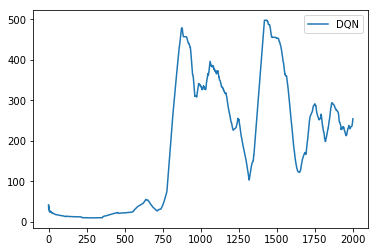

In [8]:
def dqn():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    random.seed(123)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DQNAgent(state_size, action_size)

    dqn_avg_rewards = []
    scores = deque(maxlen=100)

    for e in range(2000):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        while not done:
            # get action for the current state and go one step in environment
            action = agent.policy(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # save the sample <s, a, r, s', done> to the replay memory
            agent.append_sample(state, action, reward, next_state, done)
            # every time step do the training
            agent.train_model()

            score += reward
            state = next_state

            if done:
                # every episode update the target model to be same with model
                agent.update_target_model()

                scores.append(score)
                dqn_avg_rewards.append(np.mean(scores))
                if (e%250==0):
                    print("Episode:" + str(e) +" | Avg Reward: " + str(dqn_avg_rewards[e]))
    
    return dqn_avg_rewards
                    
# plot
dqn_avg_rewards = dqn()
plt.plot(range(2000),dqn_avg_rewards[0:2000])
# plt.plot(range(2000),reinforce_avg_rewards[0:2000])
plt.legend(["DQN"])
plt.show()

Training using deep neural network is slow.

I don't have the time to tune the hyper parameters. 

So, the performance of DQN look like the figure above. 

The performance increases if we train more episodes.

### From Policy Gradient to Deep Policy Gradient

Deep neural network can be used to represent the policy.

<img src="images/dpg.png"/>

Make a **DPGAgent** class with some features:
- It have a replay memory that stores sample data for later use (line 18)
- It have two neural networks: main Q-network (self.model) and target Q-network (self.target_model)
- The neural network (from line 28 to line 40):
    * Input layer is state
    * Has two hidden layer with 5 hidden units for each. We use ReLU activation function to remove 
    * Output layer is a *softmax* layer that predicts the probability of action 0 and action 1
- The policy network:
    * Use Adam optimizer
    * Use cross entropy loss function
- The **policy**:
    * The agent take action based on the output of policy network.
- **update** function: using sample from episode to update the policy network. The objective function is maximizing the total discounted reward.

In [10]:
class DPGAgent:
    def __init__(self, state_size, action_size):
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size

        # These are hyper parameters
        self.discount_factor = 0.99
        self.learning_rate = 0.001

        # create model for policy network
        self.model = self.build_model()

        # lists for the states, actions and rewards
        self.states, self.actions, self.rewards = [], [], []

    # approximate policy using Neural Network
    def build_model(self):
        model = keras.models.Sequential()
        model.add(keras.layers.Dense(units=5,
                                     input_dim=self.state_size,
                                     activation='relu'))
        model.add(keras.layers.Dense(units=5,
                                     activation='relu'))
        model.add(keras.layers.Dense(self.action_size,
                                     activation='softmax'))
        model.summary()
        model.compile(loss="categorical_crossentropy",
                      optimizer=keras.optimizers.Adam(lr=self.learning_rate))
        return model

    # Using the output of policy network, pick action stochastically
    def policy(self, state):
        policy = self.model.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=policy)[0]

    # In Policy Gradient agent uses sample returns for evaluating policy
    def discount_rewards(self, rewards):
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(0, len(rewards))):
            running_add = running_add * self.discount_factor + rewards[t]
            discounted_rewards[t] = running_add
        return discounted_rewards

    # save <s, a ,r> of each step
    def append_sample(self, state, action, reward):
        self.states.append(state)
        self.rewards.append(reward)
        self.actions.append(action)

    # update policy network every episode
    def train_model(self):
        episode_length = len(self.states)
        discounted_rewards = self.discount_rewards(self.rewards)

        update_inputs = np.zeros((episode_length, self.state_size))
        advantages = np.zeros((episode_length, self.action_size))

        for i in range(episode_length):
            update_inputs[i] = self.states[i]
            advantages[i][self.actions[i]] = discounted_rewards[i]

        self.model.fit(update_inputs, advantages, epochs=1, verbose=0)
        self.states, self.actions, self.rewards = [], [], []


This is the main boby of Deep policy gradient algorithm. It runs as follows:
1. For each iteration:
    1. Collect data samples from episode
    2. Update policy network using total discounted reward (Just maximizing the total discounted reward)

[2019-01-16 14:28:03,720] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 5)                 25        
_________________________________________________________________
dense_19 (Dense)             (None, 5)                 30        
_________________________________________________________________
dense_20 (Dense)             (None, 2)                 12        
Total params: 67
Trainable params: 67
Non-trainable params: 0
_________________________________________________________________
Episode:0 | Avg Reward: 55.0
Episode:250 | Avg Reward: 31.0
Episode:500 | Avg Reward: 42.04
Episode:750 | Avg Reward: 69.9
Episode:1000 | Avg Reward: 193.79
Episode:1250 | Avg Reward: 238.51
Episode:1500 | Avg Reward: 331.44
Episode:1750 | Avg Reward: 417.39
Episode:2000 | Avg Reward: 459.8
Episode:2250 | Avg Reward: 497.93
Episode:2500 | Avg Reward: 420.53
Episode:2750 | Avg Reward: 471.04


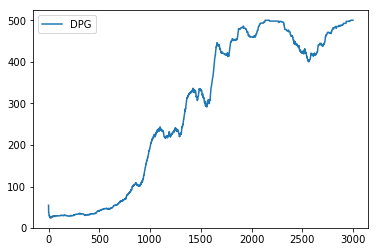

In [11]:
def dpg():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    random.seed(123)
    tf.set_random_seed(123)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DPGAgent(state_size, action_size)

    dpg_avg_rewards = []
    scores = deque(maxlen=100)

    for e in range(3000):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])

        while not done:
            action = agent.policy(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            # save the sample <s, a, r> to the memory
            agent.append_sample(state, action, reward)

            score += reward
            state = next_state

            if done:
                agent.train_model()

        scores.append(score)
        dpg_avg_rewards.append(np.mean(scores))
        if (e % 250 == 0):
            print("Episode:" + str(e) + " | Avg Reward: " + str(dpg_avg_rewards[e]))

    return dpg_avg_rewards

# plot
dpg_avg_rewards = dpg()
plt.plot(range(3000),dpg_avg_rewards[0:3000])
# plt.plot(range(3000),reinforce_avg_rewards[0:3000])
plt.legend(["DPG"])
plt.show()

### From Actor Critic to Deep Actor Critic

In the Deep Actor Critic, we approximate both actor part and critic part using deep neural network. Particularly, in this example,
1. Actor network:
    * Input is state
    * Output is softmax
    * One hidden layer with 5 units
2. Critic network:
    * Input is state
    * Output is V value
3. Policy: softmax policy
4. 

In [17]:
class DACAgent:
    def __init__(self, state_size, action_size):
        # if you want to see Cartpole learning, then change to True
        self.render = False
        self.load_model = False
        # get size of state and action
        self.state_size = state_size
        self.action_size = action_size
        self.value_size = 1

        # These are hyper parameters for the Policy Gradient
        self.discount_factor = 0.99
        self.actor_lr = 0.001
        self.critic_lr = 0.005

        # create model for policy network
        self.actor = self.build_actor()
        self.critic = self.build_critic()

    # Actor network
    def build_actor(self):
        actor = keras.models.Sequential()
        actor.add(keras.layers.Dense(units=5,
                                     input_dim=self.state_size,
                                     activation='relu'))
        actor.add(keras.layers.Dense(self.action_size,
                                     activation='softmax'))
        actor.summary()
        actor.compile(loss='categorical_crossentropy',
                      optimizer=keras.optimizers.Adam(lr=self.critic_lr))
        return actor

    # Critic network
    def build_critic(self):
        critic = keras.models.Sequential()
        critic.add(keras.layers.Dense(units=5,
                                      input_dim=self.state_size,
                                      activation='relu'))
        critic.add(keras.layers.Dense(self.value_size,
                                      activation='linear'))
        critic.summary()
        critic.compile(loss="mse",
                       optimizer=keras.optimizers.Adam(lr=self.critic_lr))
        return critic

    # using the output of policy network, pick action stochastically
    def policy(self, state):
        probs = self.actor.predict(state, batch_size=1).flatten()
        return np.random.choice(self.action_size, 1, p=probs)[0]

    # update policy network every episode
    def train_model(self, state, action, reward, next_state, done):
        target = np.zeros((1, self.value_size))
        advantages = np.zeros((1, self.action_size))

        value = self.critic.predict(state)[0]
        next_value = self.critic.predict(next_state)[0]

        if done:
            advantages[0][action] = reward - value
            target[0][0] = reward
        else:
            advantages[0][action] = reward + self.discount_factor * next_value - value
            target[0][0] = reward + self.discount_factor * next_value
            
        self.critic.fit(state, target, epochs=1, verbose=0)
        self.actor.fit(state, advantages, epochs=1, verbose=0)

In [ ]:
def dac():
    env = gym.make('CartPole-v1')
    np.random.seed(123)
    env.seed(123)
    random.seed(123)
    tf.set_random_seed(123)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.n
    agent = DACAgent(state_size, action_size)

    dac_avg_rewards = []
    scores = deque(maxlen=100)

    for e in range(3000):
        done = False
        score = 0
        state = env.reset()
        state = np.reshape(state, [1, state_size])
        while not done:
            action = agent.policy(state)
            next_state, reward, done, info = env.step(action)
            next_state = np.reshape(next_state, [1, state_size])

            agent.train_model(state, action, reward, next_state, done)

            score += reward
            state = next_state

            if done:
                break

        scores.append(score)
        dac_avg_rewards.append(np.mean(scores))
        if (e % 250 == 0):
            print("Episode:" + str(e) + " | Avg Reward: " + str(dac_avg_rewards[e]))

    return dac_avg_rewards

# plot
dac_avg_rewards = dac()
plt.plot(range(3000),dac_avg_rewards[0:3000])
# plt.plot(range(3000),dpg_avg_rewards[0:3000])
# plt.plot(range(3000),reinforce_avg_rewards[0:3000])
plt.legend(["DAC"])
plt.show()

[2019-01-16 15:39:37,492] Making new env: CartPole-v1


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_33 (Dense)             (None, 5)                 25        
_________________________________________________________________
dense_34 (Dense)             (None, 2)                 12        
Total params: 37
Trainable params: 37
Non-trainable params: 0
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_35 (Dense)             (None, 5)                 25        
_________________________________________________________________
dense_36 (Dense)             (None, 1)                 6         
Total params: 31
Trainable params: 31
Non-trainable params: 0
_________________________________________________________________
Episode:0 | Avg Reward: 19.0
Episode:250 | Avg Reward: 67.27


### Other algorithms

Nowadays, although a lot RL algorithms are proposed, they still inherit properties:

1. On-policy or off-policy algorithm.
2. Q function approximation using Deep neural network.
3. Actor critic architecture.
4. Natural Policy Gradient (PPO, TRPO) vs Vanilla Policy Gradient (DDPG, A3C, A2C).
5. Policy-based vs Value-based
6. Episodic-based vs Step-based

You can also write your own RL algorithms.

# Research Areas?

### Auto Machine Learning (AutoML)

Hyper-parameters in RL: learning rate ($\alpha$), discounted factor ($\gamma$), learning rate decay, epsilon, number of hidden layer, number of hidden units for each layer.

The question is how to obtain optimal hyper-parameters. The answer is **AutoML**

AutoML provides a way to select models and optimize hyper-parameters.

### Hierarchial Reinforcement Learning



### Planning under Partial Observability

### Meta learning

# Conclusion?

Depend on the specified problem, we can pick up the appropriate RL algorithm (not nessesary deep algorithms).

### The process to solve the problem with RL algorithms:

1. Determine the input and output values of the problem

2. Build random, heuristic algorithms (baseline)

3. Build RL algorithms: build deep network, write algorithm

4. Running the algorithms and tuning hyperparameters (using AutoML)

4. Improve algorithms by: normalizing input, adding more inputs, prevent overfiting (adding regularizer, dropout,...)

# References

1. RL course of David Silver: http://www0.cs.ucl.ac.uk/staff/d.silver/web/Teaching.html
2. RL Code: https://github.com/rlcode